In [1]:
import os
import re

In [2]:
!pip install pandas

In [17]:
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [83]:
# !pip install psycopg2
# import psycopg2

In [84]:
# %load_ext sql

# TASK 1

In [3]:
HOST = "localhost"
DB = "tweetsDB"
USER = "postgres"
PASSWD = "passwd"

In [86]:
# conn = psycopg2.connect(dbname=DB, user=USER, password=PASSWD, host=HOST)

In [87]:
# cur = conn.cursor()

In [88]:
# cur.execute(query)

In [89]:
# cur.fetchall()

In [90]:
# res = cur.execute("SELECT * FROM hashtags LIMIT 100")

In [91]:
# print(res)

In [4]:
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, String, Integer, MetaData
from sqlalchemy.orm import declarative_base, sessionmaker

In [5]:
posgres_conn_str = f"postgresql://{USER}:{PASSWD}@{HOST}/{DB}"

In [6]:
engine = create_engine(posgres_conn_str)

# TASK 2

TODO:

    1. vytvorit si novy stlpec pre sentiment(neg, neu, pos, compound)
    2. joinut tweety s tweethashtagmi s hashtagmi 
    3. vyfiltrovat podla danych hashtagov, ktore chcem 
    4. vypocitat sentiment a zapisat do DB

Adding the sentiment columns to the tweets table

In [266]:
add_columns_query = """

    BEGIN TRAN 

    ALTER TABLE tweets
    ADD COLUMN neg numeric(6, 4),
    ADD COLUMN neu numeric(6, 4),
    ADD COLUMN pos numeric(6, 4),
    ADD COLUMN compound numeric(6, 4)

    COMMIT TRAN 

"""

In [8]:
try:
    engine.execute(add_columns_query)
    engine.commit()
except:
    print("Columns probably already exist")

Columns probably already exist


In [8]:
HASHTAG_FILTER = """'%%DeepstateVirus%%', '%%DeepStateVaccine%%','%%DeepStateFauci%%', '%%QAnon%%', '%%Agenda21%%', '%%CCPVirus%%', '%%ClimateChangeHoax%%',
'%%GlobalWarmingHoax%%', '%%ChinaLiedPeopleDied%%', '%%SorosVirus%%', '%%5GCoronavirus%%', '%%MAGA%%',
'%%WWG1WGA%%', '%%Chemtrails%%', '%%flatEarth%%', '%%MoonLandingHoax%%', '%%moonhoax%%', '%%illuminati%%',
'%%pizzaGateIsReal%%', '%%PedoGateIsReal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"""

In [7]:
# hashtag : conspiracy_theory
CONSPIRACY_THEORIES = {
 
        "deepstatevirus"                :   "Deep State",  
        "deepstatevaccine"              :   "Deep State",
        "deepstatefauci"                :   "Deep State",
        "qanon"                         :   "Qanon",
        "maga"                          :   "Qanon",
        "wwg1wga"                       :   "Qanon",
        "agenda21"                      :   "New world order",
        "ccpvirus"                      :   "The virus escaped from a Chinese lab", 
        "chinaliedpeopledied"           :   "The virus escaped from a Chinese lab",
        "climatechangehoax"             :   "GLobal Warming is HOAX",
        "globalwarminghoax"             :   "GLobal Warming is HOAX",
        "sorosvirus"                    :   "COVID19 and microchipping", 
        "billgates"                     :   "COVID19 and microchipping",
        "5gcoronavirus"                 :   "COVID19 is preaded by 5G",
        "moonlandinghoax"               :   "Moon landing is fake", 
        "moonhoax"                      :   "Moon landing is fake",
        "911truth"                      :   "9/11 was inside job",
        "911insidejob"                  :   "9/11 was inside job",
        "pizzagateisreal"               :   "Pizzagate conspiracy theory",
        "pedogateisreal"                :   "Pizzagate conspiracy theory",   
        "chemtrails"                    :   "Chemtrails",
        "flatearth"                     :   "FlatEarth",
        "illuminati"                    :   "Illuminati",
        "reptilians"                    :   "Reptilian conspiracy theory"
}

In [8]:
CONSPIRACY_THEORIES.get("DeepStateVaccine")

We need to match all the mutations of the hashtags:

In [16]:
filter_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array[{HASHTAG_FILTER.lower()}])
"""

In [14]:
filter_query

"\n    SELECT * \n    FROM hashtags\n    WHERE lower(value) LIKE ANY (array['%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'])\n"

In [274]:
qanon_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array['qanon'])
"""

In [275]:
df_qanon = pd.read_sql(qanon_query, engine)

In [17]:
df_filtered = pd.read_sql(filter_query, engine)

In [18]:
df_filtered

,id,value
0,15690756,qANON
1,15696429,QanonDeutsch
2,15761297,WHMAGA
3,15789032,WWG1WGAWARRIORS
4,15806121,Pizzagateisreal
...,...,...
2013,66445,Agenda21
2014,3794870,WWG1WGAWorldWide
2015,158957,MAGA2020
2016,59789,MAGAts


In [278]:
df_qanon

,id,value
0,21259243,QAnON
1,15690756,qANON
2,15177935,qAnon
3,16799781,qanOn
4,18387797,QanON
5,27195,QANON
6,22837040,QanoN
7,25091,qanon
8,22849188,QanOn
9,15168832,QANOn


We can see that hoaxer dont know grammar

In [63]:
emoji_pat = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        # u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        # u"\U00002702-\U000027B0"
        # u"\U000024C2-\U0001F251"  # mandarinian chars
        u"\U00010000-\U0010ffff"
        u"\U0001f926-\U0001f937"
        u"\u2600-\u2B55"
        u"\u2640-\u2642" 
        u"\u200d"
        u"\u231a"
        u"\u23e9"
        u"\u23cf"
        u"\ufe0f"  # dingbats
        u"\u3030"
                        "]+", flags = re.UNICODE)




def parse_line(line):
    # res = re.sub("(\#|\@)[\w]+", "", line)
    res = re.sub("[#@]+[\w.-]*", "", line)
    res = emoji_pat.sub(r'',res)
    return res.lstrip().rstrip()

In [64]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def compute_sentiment_and_write(line):
    # parse the line and compute the sentiment
    id = line['id']
    sentiment = sid.polarity_scores(parse_line(line['content']))
    # print(parse_line(line['content']))
    # print(sid.polarity_scores(parse_line(line['content'])))
    try:
        engine.execute(f"""
            BEGIN TRAN 

            UPDATE tweets
            SET neg = {sentiment['neg']},
                neu = {sentiment['neu']},
                pos = {sentiment['pos']},
                compound = {sentiment['compound']}
            WHERE id = '{id}';

            COMMIT TRAN 
        """)
        
    except:
        print("Something went wrong during write")




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kdeni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
lower_hastag_filter = HASHTAG_FILTER.lower()

In [13]:
lower_hastag_filter

"'%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"

In [14]:
query = f"""
                SELECT tweets.id as tweetID, tweets.content, h.id as hashtagID, h.value as hashtagVal
                FROM tweets
                JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
                JOIN hashtags as h ON h.id = th.hashtag_id
                WHERE lower(h.value) ILIKE ANY (array[{lower_hastag_filter}])
        
"""

In [24]:
query_hash = f"""
        SELECT value
        FROM hashtags as h
        WHERE lower(h.value) ILIKE ANY (array[{lower_hastag_filter}])
"""

In [24]:
query_hash

"\n        SELECT value\n        FROM hashtags as h\n        WHERE lower(h.value) ILIKE ANY (array['%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'])\n"

In [25]:
df_some = pd.read_sql(query_hash, engine)

In [26]:
df_some

,value
0,agenda21
1,keralalifemagazine
2,MAGAValentinesGifts
3,TrueMAGA
4,Magazines
...,...
2013,WWG1WGA
2014,MAGA
2015,QanonIsTruth
2016,QanonSharp


In [15]:
df_filtered_tweets = pd.read_sql(query, engine)

In [62]:
df_filtered_tweets['content'][20]

'Coronavirus, Organic or Purposely Released? https://t.co/URK2lIpxbV \n\n#WWG1WGA'

In [17]:
df_filtered_tweets['hashtagval'] = df_filtered_tweets['hashtagval'].apply(lambda x: x.lower()) 

Remove duplicates

In [18]:
df_unique_filtered_tweets = df_filtered_tweets.drop_duplicates(subset=['tweetid'])

In [38]:
df_unique_filtered_tweets["content"][995]

'RT @alireza_areff: 中国人民需要知道，过去几十年来，中国政府通过支持伊朗的恐怖主义政权向伊朗发送了#Coronavirus。\n 伊朗政权已经用中国政府付给他们的钱杀死并监禁了数百人。\n #MAGA #MIGA https://t.co/A0tRIavjDP\n#…'

In [20]:
df_filtered_tweets

,tweetid,content,hashtagid,hashtagval
0,1220491726214717440,I didn't say a word about #QAnon in my tweets ...,20506,qanon
1,1220786014006009856,Update: #Coronavirus Is Spreading In The US No...,14415,maga
2,1220789297474916355,@being_nontheist @SenatorDurbin @Lawrence @Sen...,18287,wwg1wga_worldwide
3,1220797748502417409,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
4,1220796328265101312,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
...,...,...,...,...
3656137,1255962361866878986,The ugly face of the #CCP hidden behind the #C...,1137275,ccpvirus
3656138,1256433969240956932,Toutes les innovations du CES 2020 🙂😊👌🏾🔥... si...,15552438,5gcoronavirus
3656139,1256462861343141888,Happy day! #saturdayvibes #weekendfun #weekend...,36548271,ritzmagazine
3656140,1256462924719239168,Hey #lockdown #protest ers. The ice is danger...,14415,maga


In [23]:
filtered = df_filtered_tweets.apply(lambda x: parse_line(x['content']), axis=1)

In [26]:
type(filtered)

pandas.core.series.Series

In [36]:
for i in range(0, 1000):
    print(f"Number[{i}]: {filtered[i]}")
    print("------------------------")

Number[0]: I didn't say a word about  in my tweets re: the coronavirus and vaccines, but nevertheless fake news Buzzfeed used them to throw shade on Q.

Nor did I say "Bill Gates created it" either.

Try as they may 

https://t.co/tWOVlRKs5M
------------------------
Number[1]: Update:  Is Spreading In The US Now  Said There Are 3 People Infected With The Virus ! 46 Million  Are Now Under  - More Than The Entire State Of California ! Trump2020       https://t.co/jWHITa9xWo
------------------------
Number[2]: The CDC is corrupt beyond belief. Too many flip flops back and forth from pharma. Time for a great awakening. Man made outbreak. This has been planned for some time.     
https://t.co/H5cqROdTWY
------------------------
Number[3]: RT : I didn't say a word about  in my tweets re: the coronavirus and vaccines, but nevertheless fake news Buzzfeed use…
------------------------
Number[4]: RT : I didn't say a word about  in my tweets re: the coronavirus and vaccines, but nevertheless fake

In [244]:
'magazine' in df_filtered_tweets.value.values

True

Computing the sentiment and writing it to the db

In [255]:
id_count = len(df_filtered_tweets)

In [316]:
df_unique_filtered_tweets.apply(lambda x: compute_sentiment_and_write(x), axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
3656131    None
3656133    None
3656134    None
3656135    None
3656140    None
Length: 2152424, dtype: object

In [246]:
# for (id, sentiment) in new_col:

#     engine.execute(f"""
#         UPDATE tweets
#         SET neg = {sentiment['neg']},
#             neu = {sentiment['neu']},
#             pos = {sentiment['pos']},
#             compound = {sentiment['compound']}
#         WHERE id = '{id}';
#     """)


# TASK 3

Creating the consp_theory tables as well the link between hashtags and consptheory

In [32]:
consp_theory_link = df_filtered_tweets.loc[ : , ["hashtagid", "hashtagval", "tweetid"]]

In [33]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [34]:
consp_theory_link = consp_theory_link.drop_duplicates()

In [35]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [36]:
consp_theory_link[consp_theory_link['tweetid'] == str(1256801279139069952)]

,hashtagid,hashtagval,tweetid
18393,20506,qanon,1256801279139069952
18394,15171991,chemtrails,1256801279139069952
18395,25089,wwg1wga,1256801279139069952
18396,259500,wwg1wgaworldwide,1256801279139069952


In [37]:
consp_theory_link = consp_theory_link.reset_index(drop=True)

In [50]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [33]:
CONSPIRACY_THEORIES.get(consp_theory_link['hashtagval'][2015])

'Qanon'

In [34]:
CONSPIRACY_THEORIES.get("some")

In [35]:
consp_theory_link['hashtagval'][2015]

'wwg1wga'

Get the name of the consp. theory.

In [51]:
consp_theory_link

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,14415,maga,1220728654327664640
2,18287,wwg1wga_worldwide,1220789297474916355
3,20506,qanon,1220796328265101312
4,14415,maga,1220796147759026176
...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986
3656138,3073063,ccpvirus,1256457162148233219
3656139,15552438,5gcoronavirus,1256433969240956932
3656140,14415,maga,1256462924719239168


In [9]:
CONSPIRACY_THEORIES_LIST = list(CONSPIRACY_THEORIES.keys())
THEORY_LIST = list(set(CONSPIRACY_THEORIES.values()))

def chceck_theory(hashtag):
    for key in CONSPIRACY_THEORIES_LIST:
        if key in hashtag:
            return CONSPIRACY_THEORIES.get(key)


Mapping the hashtag to the theory name.

In [53]:
# consp_theory_link['theory'] = consp_theory_link.apply(lambda x: CONSPIRACY_THEORIES.get(x["hashtagval"]), axis=1)
consp_theory_link['theory'] = consp_theory_link.apply(lambda x: chceck_theory(x['hashtagval']), axis=1)

In [211]:
# for index, row  in consp_theory_link.iterrows():
#     print(row['hashtagid'], row['hashtagval'])

20506 qanon
25089 wwg1wga
20506 qanon
25089 wwg1wga
77112 qanon
511508 wwg1wga
25091 qanon
20506 qanon
77112 qanon
25089 wwg1wga
77112 qanon
77112 qanon
20506 qanon
77112 qanon
25089 wwg1wga
14415 maga
77112 qanon
20506 qanon
15291661 qanongermany
21776040 qanondach
77112 qanon
25089 wwg1wga
259500 wwg1wgaworldwide
20506 qanon
25089 wwg1wga
20506 qanon
14415 maga
20506 qanon
158957 maga2020
20506 qanon
20506 qanon
20506 qanon
20506 qanon
14415 maga
77112 qanon
20506 qanon
17457016 obamagate
25089 wwg1wga
20506 qanon
20506 qanon
14415 maga
25089 wwg1wga
20506 qanon
25089 wwg1wga
20506 qanon
25089 wwg1wga
20506 qanon
25089 wwg1wga
20506 qanon
488582 obamagate
25089 wwg1wga
20506 qanon
77112 qanon
25089 wwg1wga
20506 qanon
25091 qanon
259500 wwg1wgaworldwide
20506 qanon
20506 qanon
20506 qanon
25089 wwg1wga
259500 wwg1wgaworldwide
20506 qanon
20506 qanon
14415 maga
20506 qanon
20506 qanon
158957 maga2020
6484683 maga2020
20506 qanon
20506 qanon
20506 qanon
158957 maga2020
20506 qanon
2508

KeyboardInterrupt: 

In [54]:
consp_theory_link

,hashtagid,hashtagval,tweetid,theory
0,14415,maga,1220786014006009856,Qanon
1,14415,maga,1220728654327664640,Qanon
2,18287,wwg1wga_worldwide,1220789297474916355,Qanon
3,20506,qanon,1220796328265101312,Qanon
4,14415,maga,1220796147759026176,Qanon
...,...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986,The virus escaped from a Chinese lab
3656138,3073063,ccpvirus,1256457162148233219,The virus escaped from a Chinese lab
3656139,15552438,5gcoronavirus,1256433969240956932,COVID19 is preaded by 5G
3656140,14415,maga,1256462924719239168,Qanon


In [55]:
consp_values = list(set(CONSPIRACY_THEORIES.values()))

In [59]:
id_arr = [x for x in range(1, len(consp_values) + 1)]

In [60]:
# id_arr

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [61]:
consp_theory_tab = pd.DataFrame(list(zip(id_arr, consp_values)), columns=["id", "theory_name"])

In [62]:
consp_theory_tab

,id,theory_name
0,1,COVID19 and microchipping
1,2,Moon landing is fake
2,3,Chemtrails
3,4,Reptilian conspiracy theory
4,5,COVID19 is preaded by 5G
5,6,The virus escaped from a Chinese lab
6,7,Qanon
7,8,GLobal Warming is HOAX
8,9,FlatEarth
9,10,New world order


In [304]:
try:
    engine.execute("""
        BEGIN TRAN 

        CREATE TABLE IF NOT EXISTS consp_theories (
        id INT GENERATED ALWAYS AS IDENTITY,
        theory_name varchar(255),
        PRIMARY KEY(id)
    );   

        COMMIT TRAN 
    """)
except:
    print("Something went wrong")

Inserting the consp_theories

In [305]:
try:
    for _, row in consp_theory_tab.iterrows():
        engine.execute(f"""
            BEGIN TRAN 
            INSERT INTO consp_theories(theory_name)
            VALUES ('{row['theory_name']}');
            COMMIT TRAN   
        """)
except:
    print("Somthing went wrong")

In [64]:
df_theories = pd.read_sql(
    """
    SELECT id, theory_name
    FROM 
    consp_theories
    """
    , engine)

In [65]:
df_theories['theory_name']

0                      9/11 was inside job
1     The virus escaped from a Chinese lab
2              Reptilian conspiracy theory
3                               Chemtrails
4                   GLobal Warming is HOAX
5              Pizzagate conspiracy theory
6                          New world order
7                                    Qanon
8                               Deep State
9                     Moon landing is fake
10                              Illuminati
11                COVID19 is preaded by 5G
12               COVID19 and microchipping
13                               FlatEarth
Name: theory_name, dtype: object

In [66]:
df_theories

,id,theory_name
0,1,9/11 was inside job
1,2,The virus escaped from a Chinese lab
2,3,Reptilian conspiracy theory
3,4,Chemtrails
4,5,GLobal Warming is HOAX
5,6,Pizzagate conspiracy theory
6,7,New world order
7,8,Qanon
8,9,Deep State
9,10,Moon landing is fake


In [67]:
mapping_dict = dict(zip(df_theories['theory_name'], df_theories['id']))

In [68]:
mapping_dict

{'9/11 was inside job': 1,
 'The virus escaped from a Chinese lab': 2,
 'Reptilian conspiracy theory': 3,
 'Chemtrails': 4,
 'GLobal Warming is HOAX': 5,
 'Pizzagate conspiracy theory': 6,
 'New world order': 7,
 'Qanon': 8,
 'Deep State': 9,
 'Moon landing is fake': 10,
 'Illuminati': 11,
 'COVID19 is preaded by 5G': 12,
 'COVID19 and microchipping': 13,
 'FlatEarth': 14}

In [69]:
consp_theory_link['theory_id'] = consp_theory_link.apply(lambda x: mapping_dict.get(x['theory']), axis=1)

In [70]:
consp_theory_link

,hashtagid,hashtagval,tweetid,theory,theory_id
0,14415,maga,1220786014006009856,Qanon,8
1,14415,maga,1220728654327664640,Qanon,8
2,18287,wwg1wga_worldwide,1220789297474916355,Qanon,8
3,20506,qanon,1220796328265101312,Qanon,8
4,14415,maga,1220796147759026176,Qanon,8
...,...,...,...,...,...
3656137,1137275,ccpvirus,1255962361866878986,The virus escaped from a Chinese lab,2
3656138,3073063,ccpvirus,1256457162148233219,The virus escaped from a Chinese lab,2
3656139,15552438,5gcoronavirus,1256433969240956932,COVID19 is preaded by 5G,12
3656140,14415,maga,1256462924719239168,Qanon,8


In [71]:
hash_consp_mapping = consp_theory_link.loc[:, ['hashtagid', 'theory_id']]

In [72]:
hash_consp_mapping = hash_consp_mapping.drop_duplicates(subset=['hashtagid'])

In [73]:
hash_consp_mapping.dtypes

hashtagid    int64
theory_id    int64
dtype: object

In [74]:
hash_consp_mapping

,hashtagid,theory_id
0,14415,8
2,18287,8
3,20506,8
8,25089,8
9,24818,8
...,...,...
3655885,37283281,8
3655889,37295422,8
3655979,37375431,8
3656027,37408594,8


In [75]:
hash_consp_mapping['hashtagid'] = hash_consp_mapping['hashtagid'].astype(int)
hash_consp_mapping = hash_consp_mapping.dropna()
hash_consp_mapping['theory_id'] = hash_consp_mapping['theory_id'].astype(int)

In [76]:
hash_consp_mapping

,hashtagid,theory_id
0,14415,8
2,18287,8
3,20506,8
8,25089,8
9,24818,8
...,...,...
3655885,37283281,8
3655889,37295422,8
3655979,37375431,8
3656027,37408594,8


Adding the mapping between theories and hashtags

In [79]:
try:
    engine.execute("""
        BEGIN;

        CREATE TABLE IF NOT EXISTS hash_consptheories_link (
        id int GENERATED ALWAYS AS IDENTITY,
        hashtag_id int,
        consp_theory_id int,
        PRIMARY KEY(id),
        CONSTRAINT fk_hashtag
            FOREIGN KEY(hashtag_id)
                REFERENCES hashtags(id)
                ON DELETE SET NULL,

        CONSTRAINT fk_consptheory        
            FOREIGN KEY(consp_theory_id)
                REFERENCES consp_theories(id)
                ON DELETE SET NULL
    );  

    COMMIT; 
    """)
    
except:
    print("Something went wrong")

In [80]:
try:
    for _, row in hash_consp_mapping.iterrows():
        # print(row['theory_name'])
        engine.execute(f"""
            BEGIN;
            INSERT INTO hash_consptheories_link(hashtag_id, consp_theory_id)
            VALUES ('{int(row['hashtagid'])}', '{int(row['theory_id'])}');
            COMMIT;
        """)
#         # consp_theory_tab.to_sql('consp_theories', engine, if_exists='replace', index=False)
except:
    print("Somthing went wrong")

# TASK 4

In [ ]:
print("Something")

In [10]:
sentiment_query = """
    SELECT res.theory, res.week, count(res.compound) as tweet_count, sum(abs(res.compound)) as tweet_extreme_count, sum(abs(res.neu)) as tweet_neutral_count
    FROM 
    (
        SELECT tweets.compound, tweets.neu, EXTRACT(WEEK from tweets.happened_at) as week, ct.theory_name as theory
            FROM tweets
            JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
            JOIN hashtags as h ON h.id = th.hashtag_id
            JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
            JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
            WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
            group by (ct.theory_name, week, tweets.compound, tweets.neu)
        ) as res
        
    GROUP BY (res.week, res.theory)
    ORDER BY res.theory
"""

In [12]:
try:
    df_week_extreme_comp = pd.read_sql(sentiment_query, engine)
except:
    print("Something went wrong")

In [13]:
df_week_extreme_comp

,theory,week,tweet_count,tweet_extreme_count,tweet_neutral_count
0,9/11 was inside job,5.0,1,0.5574,0.662
1,9/11 was inside job,8.0,1,0.6486,0.654
2,9/11 was inside job,15.0,3,1.9305,2.405
3,9/11 was inside job,16.0,2,1.1513,1.524
4,9/11 was inside job,18.0,4,2.9012,2.837
...,...,...,...,...,...
147,The virus escaped from a Chinese lab,18.0,194,133.9077,135.210
148,The virus escaped from a Chinese lab,19.0,122,84.1172,86.548
149,The virus escaped from a Chinese lab,20.0,62,44.4345,45.342
150,The virus escaped from a Chinese lab,21.0,3,2.0589,2.032


In [14]:
df_week_extreme_comp['week'] = df_week_extreme_comp['week'].astype(int)


    #######
    ---  9/11 was inside job ---
    ######
                    theory  week  tweet_count  tweet_extreme_count  \
0  9/11 was inside job     5            1               0.5574   
1  9/11 was inside job     8            1               0.6486   
2  9/11 was inside job    15            3               1.9305   
3  9/11 was inside job    16            2               1.1513   
4  9/11 was inside job    18            4               2.9012   
5  9/11 was inside job    19            2               1.4732   
6  9/11 was inside job    22            2               1.1809   

   tweet_neutral_count  
0                0.662  
1                0.654  
2                2.405  
3                1.524  
4                2.837  
5                1.481  
6                1.744  
    
    (<Figure size 432x288 with 1 Axes>, [<matplotlib.lines.Line2D object at 0x0000028CF7554190>], [<matplotlib.lines.Line2D object at 0x0000028CF7554460>], <matplotlib.legend.Legend object at 0x0000028CF75

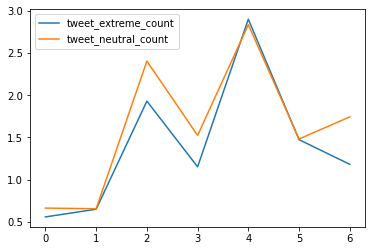

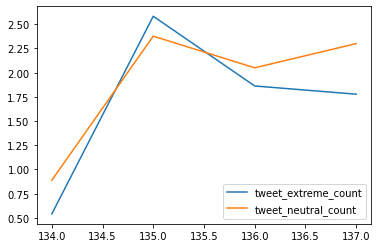

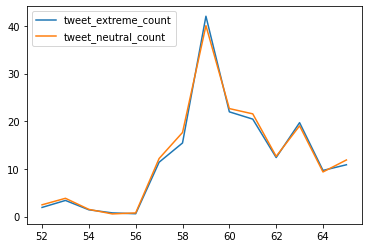

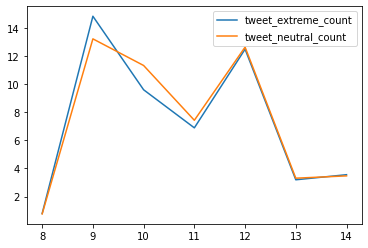

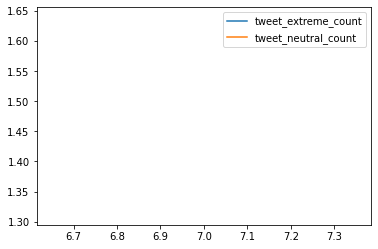

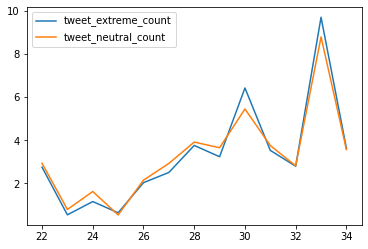

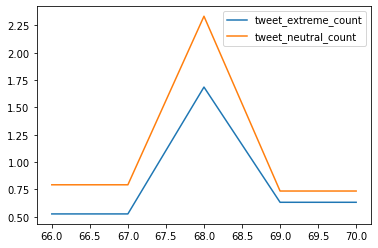

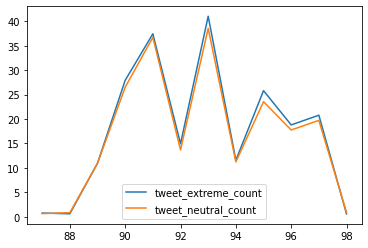

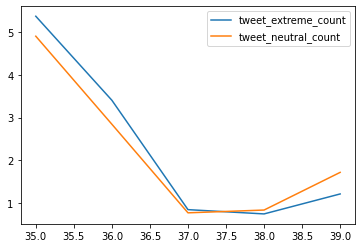

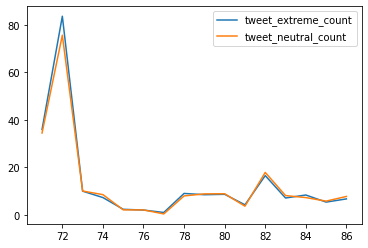

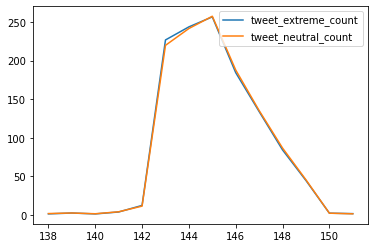

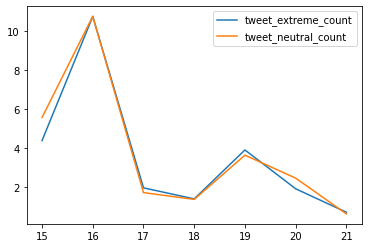

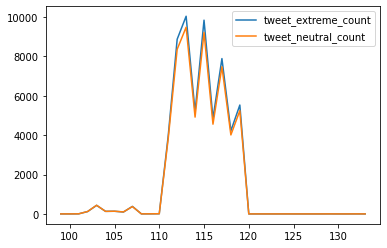

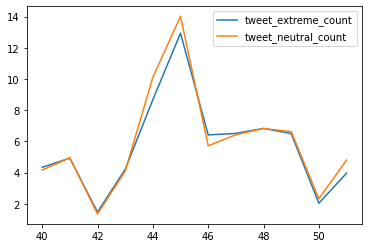

In [28]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_week_extreme_comp[df_week_extreme_comp['theory'] == name]}
    
    {plt.figure(),
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_extreme_count'], label="tweet_extreme_count"),
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_neutral_count'], label="tweet_neutral_count"),
    plt.legend()}
    
    """)
    

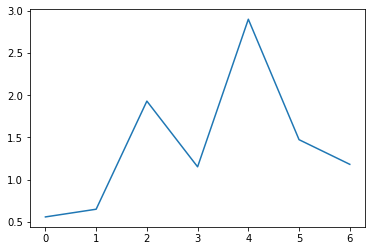

In [21]:
plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == "9/11 was inside job"]['tweet_extreme_count'], label="tweet_extreme_count")

# TASK 5

In [92]:
accounts_query = """
    SELECT ct.theory_name, acc.id , acc.name, acc.screen_name, count(tweets.id) as tweet_count
    FROM tweets
    JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
    JOIN hashtags as h ON h.id = th.hashtag_id
    JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
    JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
    JOIN tweet_mentions as tm ON tm.tweet_id = tweets.id
    JOIN accounts as acc ON tm.account_id = acc.id
    WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
    group by (ct.theory_name, acc.id, acc.name, acc.screen_name)
    ORDER BY ct.theory_name ASC
"""

In [93]:
try:
    df_top_accounts_for_consp = pd.read_sql(accounts_query, engine)
except:
    print("Something went wrong")

In [94]:
df_top_accounts_for_consp

,theory_name,id,name,screen_name,tweet_count
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1
3,9/11 was inside job,1173334893104967682,Anonymous Busch,AnonymousBusch,1
4,COVID19 and microchipping,23125257,George Soros,georgesoros,1
...,...,...,...,...,...
3870,The virus escaped from a Chinese lab,1381803231739846658,Vincent Wong,initialvw,1
3871,The virus escaped from a Chinese lab,1405060253159497730,The Core,SocialM85897394,1
3872,The virus escaped from a Chinese lab,1405799406113157128,Wesley Fangnats,WesFangNats,1
3873,The virus escaped from a Chinese lab,1407004701682454529,Leaih,leaih,1


In [96]:
df_top_accounts_for_consp = df_top_accounts_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])

In [97]:
df_top_accounts_for_consp

,theory_name,id,name,screen_name,tweet_count
3608,The virus escaped from a Chinese lab,2313027666,Jennifer Zeng 曾錚,jenniferatntd,113
3572,The virus escaped from a Chinese lab,1339488762,Solomon Yue,SolomonYue,96
3128,The virus escaped from a Chinese lab,14499829,World Health Organization (WHO),WHO,95
3224,The virus escaped from a Chinese lab,25073877,Donald J. Trump,realDonaldTrump,65
3833,The virus escaped from a Chinese lab,1232414456589750272,China in Focus - NTD,ChinaInFocusNTD,61
...,...,...,...,...,...
5,COVID19 and microchipping,188363529,"Alexander Soros, PhD",AlexanderSoros,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1


In [98]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_top_accounts_for_consp[df_top_accounts_for_consp['theory_name'] == name].loc[ :, ['id', 'name', 'screen_name', 'tweet_count']].head(10)}""")


    #######
    ---  9/11 was inside job ---
    ######
                        id                             name     screen_name  \
1             55905770                Miriam Selmi Reed       mimiselmi   
0             14499829  World Health Organization (WHO)             WHO   
2           2213750137                Madeleine Stäubli  MadeleineRodun   
3  1173334893104967682                  Anonymous Busch  AnonymousBusch   

   tweet_count  
1            2  
0            1  
2            1  
3            1  

    #######
    ---  FlatEarth ---
    ######
                        id                 name      screen_name  tweet_count
48  929387229880946688         Jack William    Jackszooquest            4
37            25073877      Donald J. Trump  realDonaldTrump            2
35            10228272              YouTube          YouTube            1
36            17471979  National Geographic           NatGeo            1
38            38190348               Daniel  crimesceneve

# TASK 6

In [52]:
hash_tags_query = """
SELECT ct.theory_name, res.value as hashtag_val, sum(res.tweet_count) as tweet_count
FROM
	(SELECT h.id, h.value, count(distinct(tweets.id)) as tweet_count
	FROM tweets
	JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
	JOIN hashtags as h ON h.id = th.hashtag_id
	JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
	JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
	WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
	group by (h.id)
	ORDER BY h.value ASC) as res

JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = res.id
JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
GROUP BY (ct.theory_name, res.id, res.value)
ORDER BY ct.theory_name ASC
"""

In [53]:
try:
    df_top_hashtags_for_consp = pd.read_sql(hash_tags_query, engine)
except:
    print("Something went wrong")

In [54]:
df_top_hashtags_for_consp = df_top_hashtags_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])
df_top_hashtags_for_consp['tweet_count'] = df_top_hashtags_for_consp['tweet_count'].astype(int)

In [55]:
df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == "The virus escaped from a Chinese lab"].head(10)

,theory_name,hashtag_val,tweet_count
883,The virus escaped from a Chinese lab,CCPVirus,1303
884,The virus escaped from a Chinese lab,ChinaLiedPeopleDied,954
881,The virus escaped from a Chinese lab,CCPvirus,151
885,The virus escaped from a Chinese lab,ccpvirus,26
889,The virus escaped from a Chinese lab,CCPVirus_Coronavirus,24
886,The virus escaped from a Chinese lab,chinaliedpeopledied,9
888,The virus escaped from a Chinese lab,CCPVIRUS,7
882,The virus escaped from a Chinese lab,ccpVirus,3
887,The virus escaped from a Chinese lab,CCPVirusHoax,3
894,The virus escaped from a Chinese lab,CCPVirusIsReal,2


In [66]:
THEORY_LIST

['9/11 was inside job',
 'FlatEarth',
 'Qanon',
 'Reptilian conspiracy theory',
 'Pizzagate conspiracy theory',
 'Moon landing is fake',
 'COVID19 is preaded by 5G',
 'COVID19 and microchipping',
 'GLobal Warming is HOAX',
 'Chemtrails',
 'Deep State',
 'Illuminati',
 'New world order',
 'The virus escaped from a Chinese lab']

In [58]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == name].loc[ :, ['hashtag_val', 'tweet_count']].head(10)}""")


    #######
    ---  9/11 was inside job ---
    ######
           hashtag_val  tweet_count
0         911Truth           24
1         911truth            8
2         911Truth            2
3     911insidejob            2
4  911insidejobber            1

    #######
    ---  FlatEarth ---
    ######
              hashtag_val  tweet_count
15          FlatEarth           47
14          flatearth           23
18  researchflatearth           11
16          FLATEARTH            6
21        FlatEarther            3
23   flatearthsociety            3
25   FlatEarthSociety            3
17  ResearchFlatEarth            2
24       flatearthers            2
13       FlatEarthers            1

    #######
    ---  Qanon ---
    ######
             hashtag_val  tweet_count
74             QAnon       415088
76           WWG1WGA       200215
82             Qanon       128874
72              MAGA        70332
77             qanon        65261
78             QANON        56806
92  WWG1WGAWORLDWIDE      